In [522]:
from dataclasses import dataclass
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib

import read_processed_data as rpd

In [445]:
'''
The source is mounted on a movable arm, 58.5mm from the GEM and 53mm to the cathode plane,
set to one side 59mm to the closest wall (to the right facing downstream with the alpha particle
beam)

The anode strips are 3mm wide and oriented transverse to the nominal α particle beam direction. 
The distance between the center of adjacent strips is 3.125mm
'''
dist_to_GEM = 58.8/1e3 #m
dist_to_cathode = 53/1e3 #m
dist_between_anodes = (3.125+3)/1e3 #m

#62.5 MHz for data taking freq. -> so our times need to be corrected with this to get to s units

dt_data = 1/(62.5e6) #s = 1/Hz

# print(dt_data*1000)

In [467]:
events_1500 = rpd.read("analysis/output_1300.txt")

3612.9047619047055


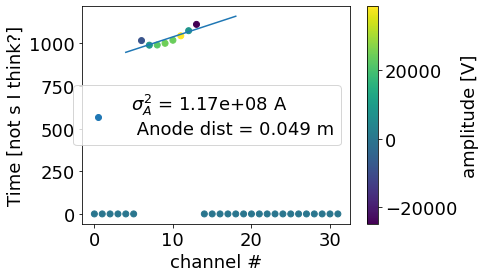

1112.0 990.0
drift time?  30122.95081967213


In [564]:
event1 = events_1500[14]
# matplotlib.rcParams.update({'font.size': 12})

# sc = plt.scatter(event1.channels, event1.amps, c=event1.times, cmap=plt.get_cmap('viridis'))
# plt.colorbar(sc, label="Time [s]")
# plt.ylabel("amplitude [V]")

AmpVar = np.var(event1.amps)
removeZerosTimes = [x for x in event1.times if x != 0]
AnodeDist = dist_between_anodes*len(removeZerosTimes)

removeZerosTimes_index = [event1.times != 0]
removeZeroChan = event1.channels[tuple(removeZerosTimes_index)]

# coeff, cov = np.polyfit(removeZeroChan, removeZerosTimes, 1, cov=True)
coeff, res, _, _, _ = np.polyfit(removeZeroChan, removeZerosTimes, 1, full= True)

sc = plt.scatter(event1.channels, event1.times, c=event1.amps, 
                 cmap=plt.get_cmap('viridis'), 
                 label="$\sigma_A^2$ = {:.2e} A\n Anode dist = {:.4} m".format(AmpVar, AnodeDist))

x = np.linspace(4, 18)

# print(np.sqrt(np.diag(cov)))
print(np.mean(res))

plt.plot(x, np.polyval(coeff, x))

plt.colorbar(sc, label="amplitude [V]")

plt.ylabel("Time [not s I think?]")
#all the tracks seem to get the min hit time at ~1000
plt.xlabel("channel #")
plt.legend()

# plt.ylim(800, 2000)
# plt.xlim(4, 15)

plt.show()

# drifttime sketch
print(np.max(removeZerosTimes), np.min(removeZerosTimes))
dt  = (np.max(removeZerosTimes) - np.min(removeZerosTimes)) * dt_data
dy = dist_to_GEM #m

print("drift time? ", dy/dt)

In [ ]:
#looking at the variance of the amplitude of the peak
#as tracks that hit a GEM should have a smaller variance -> less time
# to peter out - actually that doens't seem to help much

# AmpVar = []
# for i, event in enumerate(events_1500):
#     AmpVar.append(np.max(event.amps))
#     if np.max(event.amps) > 16e4:
#         print(i)

# plt.hist(AmpVar, bins=10)
# plt.show()

#what about just choose a channel to be our cut off?

def lastDistance(input_Arr):
#     print(input_Arr)
    
    nonZero_index = np.where(input_Arr > 0)[0]
#     print(nonZero_index))
    if len(nonZero_index) > 2:
    
        lastDist = nonZero_index[-1] - nonZero_index[-2]
    else:
        lastDist = 100
    return lastDist

LastChannel = []
for i, event in enumerate(events_1500):
#     removeZerosTimes_index = [i for i, x in enumerate(event.times) if x != 0]
    removeZerosTimes_index = [event.times != 0]
    varianceT = np.var(event.times[tuple(removeZerosTimes_index)])
#     print(varianceT)
    
    lastDist = lastDistance(event.times)
    upPaths_cut = event.times[tuple(removeZerosTimes_index)][-1] > event.times[tuple(removeZerosTimes_index)][0]
    
    if (lastDist < 2) & (np.mean(event.amps) > 0) & (varianceT > 400) & upPaths_cut: #remove signals with strange bumps in them
        noneZeroChannels = event.channels[tuple(removeZerosTimes_index)]
        LastChannel.append(noneZeroChannels[-1])
        if noneZeroChannels[-1] < 55:
            print(i)

y, x, _ = plt.hist(LastChannel, bins=16)
print(x[np.where(y == y.max())])
plt.show()

In [68]:
#find horizontal track maybe?

dt = 100

for i, event in enumerate(events_1500):
    removeZerosTimes = [x for x in event.times if x != 0]
    variance = np.var(removeZeros)
#     print(variance)
    #horizontal tracks should have basically no variance in the timing of hits
    if variance < dt & len(removeZeros) > 2: #not right
        print(i, len(removeZeros))

825 4
894 4
2680 5
5752 5


In [342]:
#get drift times
timingArr = []

for i, event in enumerate(events_1500):
    
    removeZerosTimes_index = [event.times != 0]
    
    lastDist = lastDistance(event.times)
    if lastDist < 2: #remove signals with strange bumps in them
        removeZerosTimes = [x for x in event.times if x != 0]
        #should also only look at tracks that are heading up and we think
        #hit a GEM, didn't just petter out
        varianceT = np.var(removeZerosTimes)
        varianceA = np.var(event.amps)

        noneZeroChannels = event.channels[tuple(removeZerosTimes_index)]
        LastChannel = noneZeroChannels[-1]
        meanChannel = np.round(np.mean(LastChannel))

    #     if (8 > len(removeZerosTimes) > 4) & (varianceT > 800):
        if (lastDist < meanChannel) & (np.mean(event.amps) > 0) & (varianceT > 100):

            dt  = (np.max(removeZerosTimes) - np.min(removeZerosTimes)) * dt_data
            dy = dist_to_GEM #m
        #     print(dt, dy)

            if dy/dt != np.inf:
                timingArr.append(dy/dt)
    
aveDriftTime = np.average(timingArr) #m/s
errorDriftTime = np.std(timingArr) #m/s

print(aveDriftTime, errorDriftTime)

19900.270755828784 20950.822163878587


In [594]:
def GetMeanLastChannel(dataSet):
    #get the distribution of last channels
    LastChannel = []
    for i, event in enumerate(dataSet):
    #     removeZerosTimes_index = [i for i, x in enumerate(event.times) if x != 0]
        removeZerosTimes_index = [event.times != 0]
        varianceT = np.var(event.times[tuple(removeZerosTimes_index)])

        lastDist = lastDistance(event.times)
        if (lastDist < 2) & (np.mean(event.amps) > 0) & (varianceT > 100): #remove signals with strange bumps in them
            noneZeroChannels = event.channels[tuple(removeZerosTimes_index)]
            LastChannel.append(noneZeroChannels[-1])

    meanChannel = np.round(np.mean(LastChannel))
    return meanChannel


def GetDriftTime(dataSet):
    
    meanChannel = GetMeanLastChannel(dataSet)
    
    timingArr = []

    for i, event in enumerate(dataSet):

        removeZerosTimes_index = [event.times != 0]

        lastDist = lastDistance(event.times)
        if lastDist < 2: #remove signals with strange bumps in them
            removeZerosTimes = [x for x in event.times if x != 0]
            
            #should also only look at tracks that are heading up and we think
            #hit a GEM, didn't just petter out
            varianceT = np.var(removeZerosTimes)
            varianceT_Cut = varianceT > 500
            negativeAmp_cut = np.mean(event.amps) > 0
            varianceA = np.var(event.amps)
            
            upPaths_cut = removeZerosTimes[-1] < removeZerosTimes[0]

            noneZeroChannels = event.channels[tuple(removeZerosTimes_index)]
            LastChannel = noneZeroChannels[-1]
            
            #trying to only get fairly linear paths - not currently using this
            coeff, res, _, _, _ = np.polyfit(noneZeroChannels, removeZerosTimes, 1, full=True)
            linearPath_cut = np.mean(res) < 10000

        #     if (8 > len(removeZerosTimes) > 4) & (varianceT > 800):
            if (lastDist < meanChannel) & negativeAmp_cut & varianceT_Cut & upPaths_cut:

                dt  = (np.max(removeZerosTimes) - np.min(removeZerosTimes)) * dt_data
                dy = dist_to_GEM #m
            #     print(dt, dy)

                if dy/dt != np.inf:
                    timingArr.append(dy/dt)
                    
    y, x, _ = plt.hist(timingArr, bins=25)
    plt.show()

    aveDriftTime = np.mean(timingArr) #m/s
    
    #this is almost def wrong - also huge
#     errorDriftTime = np.std(timingArr) #m/s
    
    #can we just use counting stats? -  this looks nicer lol
    errorDriftTime = np.sqrt(len(timingArr)) #m/s

    return [aveDriftTime, errorDriftTime]

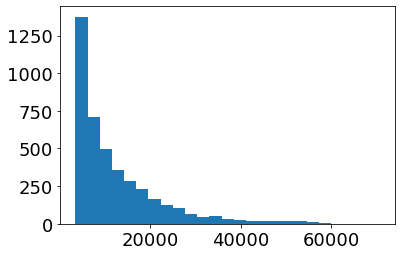

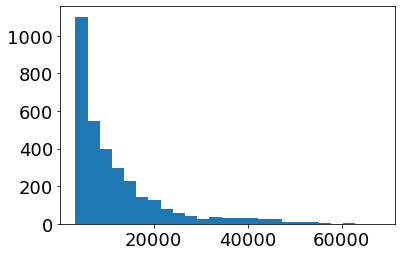

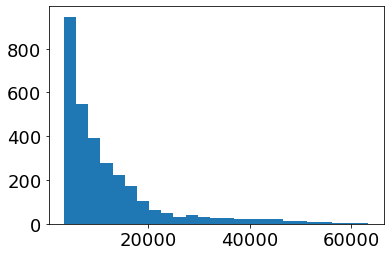

In [595]:
#getting the drift value from our three data sets to compare
DriftData = []

events_1500 = rpd.read("analysis/output_1500.txt")
DriftData.append( np.append(GetDriftTime(events_1500), 1500) )

events_1300 = rpd.read("analysis/output_1300.txt")
DriftData.append( np.append(GetDriftTime(events_1300), 1300) )

events_1100 = rpd.read("analysis/output_1100.txt")
DriftData.append( np.append(GetDriftTime(events_1100), 1100) )

DriftData = np.array(DriftData).T

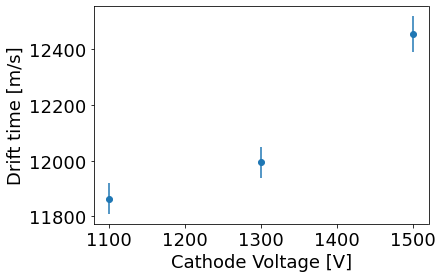

array([12454.90593811, 11993.85438212, 11864.1138891 ])

In [596]:
plt.errorbar(DriftData[2], DriftData[0], yerr = DriftData[1], marker="o", ls="")

plt.ylabel("Drift time [m/s]")
#all the tracks seem to get the min hit time at ~1000
plt.xlabel("Cathode Voltage [V]")
# plt.ylim(10000, 15000)

# plt.legend(fontsize=30)
plt.show()

DriftData[0]

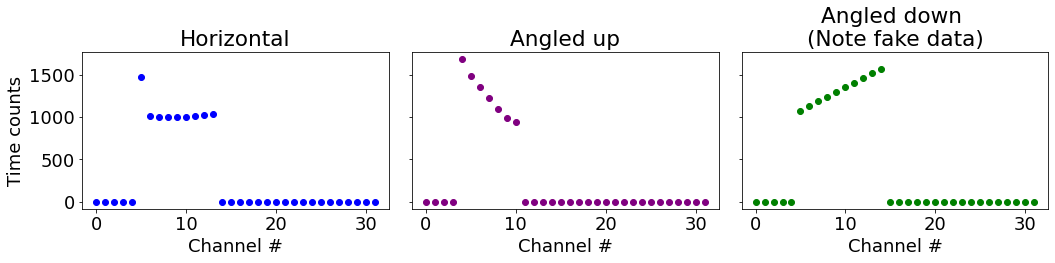

1112.0 990.0
drift time?  30122.95081967213


In [585]:

matplotlib.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

event1 = events_1500[4]
sc = ax[0].scatter(event1.channels, event1.times, c='b')
ax[0].set_title("Horizontal")

event2 = events_1500[0]
sc = ax[1].scatter(event2.channels, event2.times, c='purple')
ax[1].set_title("Angled up")

# event3 = events_1500[309]
fakeTimes = np.zeros(len(event3.channels))

for i in range(5, 15):
    fakeTimes[i] = 800 + 55*i

sc = ax[2].scatter(event3.channels, fakeTimes, c='g', label="Note fake data")
# ax[2].legend()
ax[2].set_title("Angled down \n(Note fake data)")

# 356
                   
ax[0].set_ylabel("Time counts")
#all the tracks seem to get the min hit time at ~1000
ax[0].set_xlabel("Channel #")
ax[1].set_xlabel("Channel #")
ax[2].set_xlabel("Channel #")

# plt.legend()
# plt.legend(fontsize=30)
# plt.ylim(800, 2000)
# plt.xlim(4, 15)\
# matplotlib.rcParams.update({'font.size': 22})
plt.tight_layout()
plt.show()

# drifttime sketch
print(np.max(removeZerosTimes), np.min(removeZerosTimes))
dt  = (np.max(removeZerosTimes) - np.min(removeZerosTimes)) * dt_data
dy = dist_to_GEM #m

print("drift time? ", dy/dt)